In [1]:
import sys, glob, os
from commons import convert_to_json, triq_optimization, qiskit_optimization, \
    calibration_type_enum, qiskit_compilation_enum, normalize_counts, calculate_success_rate_tvd, \
    convert_dict_binary_to_int, convert_dict_int_to_binary, sum_last_n_digits_dict
import wrappers.qiskit_wrapper as qiskit_wrapper
from wrappers.qiskit_wrapper import QiskitCircuit
import pandas as pd
import mthree
import mapomatic as mm
import mthree

from qiskit.quantum_info import SparsePauliOp
from qiskit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime.options import SamplerOptions, EstimatorOptions, DynamicalDecouplingOptions, TwirlingOptions

from qiskit_aer import AerSimulator, QasmSimulator, Aer
from qiskit.qasm2 import dumps

from datetime import datetime
import mysql.connector
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import re

CB_color_cycle = ['#1F77B4', '#AEC7E8', '#FF7F0E', '#FFBB78', '#2CA02C', '#98DF8A', '#D62728', '#FF9896',
                  '#9467BD', '#C5B0D5', '#8C564B', '#C49C94', '#E377C2', '#F7B6D2', '#7F7F7F', '#C7C7C7',
                  '#BCBD22', '#DBDB8D', '#17BECF', '#9EDAE5'
                  ]

CB_color_cycle_polar = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

markers = ['o', 'v', 'd', 's', '+', 'x', '^', '*', '<', '>', 'p', '1', '2', '3', '4']
linestyles = ['-', '--', ':', '-.', '-', '--', '-.', ':']
hatches = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*']

#calibration_sets = ["real", "avg", "recent", "decay_r"]
calibration_sets = ["real", "avg"]
# opts = ["TriQ", "SCR"]
# opts = ["TriQ"]



# MySQL connection parameters
mysql_config = {
    'user': 'handy',
    'password': 'handy',
    'host': 'localhost',
    'database': 'framework'
}

def get_cx_lines(updated_qasm, two_qubit_gates):
    # Split the code into lines
    lines = updated_qasm.split('\n')

    re_str = r'^\s*{}'.format(two_qubit_gates)
    cx_lines = [line for line in lines if re.match(re_str, line)]
    
    # Create a dictionary to store the counts of normalized 'cx' gates
    cx_counts = {}
    
    # Iterate through the 'cx' lines, normalize, and count them
    for line in cx_lines:
        qubits = re.findall(r'q\[(\d+)\],q\[(\d+)\]', line)
        if len(qubits) == 1:
            qubit1, qubit2 = sorted(map(int, qubits[0]))
            normalized_line = f"({qubit1},{qubit2})"
            
            if normalized_line in cx_counts:
                cx_counts[normalized_line] += 1
            else:
                cx_counts[normalized_line] = 1

    return cx_counts

def get_measure_lines(updated_qasm):
    lines = updated_qasm.split('\n')
    measure_lines = [line for line in lines if re.match(r'^\s*measure', line)]
    return measure_lines

def get_initial_mapping(updated_qasm):
    initial_mappings = []
    measure_lines = get_measure_lines(updated_qasm)
    for line in measure_lines:
        qubits = re.findall(r'q\[(\d+)\] -> c\[(\d+)\]', line)
        if len(qubits) == 1:
            initial_mappings.append(int(qubits[0][0]))

    return initial_mappings

def rename_opt_type(opt_type):
    new_name = opt_type

    if opt_type == "SCR_avg":
        new_name = "SCR_s_1"
    elif opt_type == "SCR_decay_15":
        new_name = "SCR_s_3"
    elif opt_type == "SCR_decay_45":
        new_name = "SCR_s_4"
        
    elif opt_type == "TriQ_avg":
        new_name = "TriQ_s_1"
    elif opt_type == "TriQ_decay_15":
        new_name = "TriQ_s_3"
    elif opt_type == "TriQ_decay_45":
        new_name = "TriQ_s_4"
        
    return new_name



In [2]:
def get_data_scale(user_id, hw_name="ibm_brisbane"):
    conn = mysql.connector.connect(**mysql_config)
    cursor = conn.cursor()

    
    sql = """
    SELECT d.created_datetime, circuit_name, compilation_name,
circuit_depth, total_two_qubit_gate, success_rate_tvd, success_rate_quasi, c.qubit, success_rate_polar, d.noise_level,
d.compilation_time, h.dd_enable, h.dd_sequence_type, h.dd_scheduling_method
FROM framework.result_header h
INNER JOIN framework.result_detail d ON h.id = d.header_id
INNER JOIN framework.metric m ON d.id = m.detail_id 
INNER JOIN framework.circuit c ON d.circuit_name = c.name 
WHERE h.status = "done" and h.user_id = {} AND h.hw_name = '{}' ORDER BY qubit, circuit_name ;
    """.format(user_id, hw_name)

     # insert to circuit
    cursor.execute(sql)
    
    results = cursor.fetchall()
    
    cursor.close()
    conn.close()
    
    opt = []
    calibration_type = []
    nassc = []
    tvd = []
    header_id = []
    hellinger = []
    total_gate = []
    total_gate_cx = []
    qubit_gate_count_1q = []
    qubit_gate_count_2q = []
    circuit_depth = []
    circuit_cost = []
    execution_time = []
    success_quasi = []
    success_quasi_std = []
    success_nassc_std = []
    success_polar = []
    cx_counts = []
    initial_mappings = []
    circuit_name = []
    qubit = []
    noise_level = []
    compilation_time = []
    dd_enable = []
    dd_sequence_type = []
    dd_scheduling_method = []

    idx = 0
    for res in results:
        _header_id, _circuit_name, opt_type, _circuit_depth, _qubit_gate_count_2q, _success_tvd,  \
        _success_quasi, _qubit, _success_polar, _noise_level, _compilation_time, \
        _dd_enable, _dd_sequence_type, _dd_scheduling_method = res
            
        header_id.append(_header_id)
        circuit_name.append(_circuit_name)
        opt.append(rename_opt_type(opt_type))
        circuit_depth.append(float(_circuit_depth))
        qubit_gate_count_2q.append(float(_qubit_gate_count_2q))
        tvd.append(float(_success_tvd))
        success_quasi.append(float(_success_quasi))

        if _success_polar != None:
            success_polar.append(float(_success_polar))
        else:
            success_polar.append(float(0))
        
        qubit.append(float(_qubit))
        noise_level.append(_noise_level)
        compilation_time.append(_compilation_time)

        tmp_dd_enable = 0
        if _dd_enable == 1:
            tmp_dd_enable = 1
        
        dd_enable.append(tmp_dd_enable)
        dd_sequence_type.append(_dd_sequence_type)
        dd_scheduling_method.append(_dd_scheduling_method)

    df = pd.DataFrame({
        'header_id': header_id,
        'circuit_name': circuit_name,
        'opt': opt,
        'circuit_depth': circuit_depth,
        'qubit_gate_count_2q': qubit_gate_count_2q,
        'TVD': tvd, 
        'quasi': success_quasi, 
        'qubit': qubit,
        #'polar': success_polar,
        #'noise_level': noise_level,
        #'compilation_time': compilation_time,
        'dd_enable': dd_enable,
        'dd_seq_type': dd_sequence_type,
        'dd_sch_method': dd_scheduling_method,
        })

    return df

In [3]:
def show_summary_bar_lines(df, opts, legends, circuits, ylim, ylabel, figsize=(12,5), 
                           width = 0.08, show_legend = True, legend_position = None, color_idx_add = 0):
    
    fig, ax = plt.subplots(figsize=figsize)
    width = width
    x = np.arange(len(circuits))
    
    for i, opt in enumerate(opts):
        if i == 0:
            color_idx_add = 0
        else:
            color_idx_add = 2

        idx_normal = i * 2
        idx_dd = (i * 2) + 1
        
        opt_data = df[(df['opt'] == opt) & (df['dd_enable'] == 0)]
        #print(opt)
        #print(opt_data)
        rects = ax.bar(x + idx_normal * width, opt_data['mean'], yerr=opt_data['std'], color=CB_color_cycle[i + color_idx_add], 
                       label=opt, width=width, capsize=2)

        opt_data_dd = df[(df['opt'] == opt) & (df['dd_enable'] == 1)]
        rects = ax.bar(x + idx_dd * width, opt_data_dd['mean'], yerr=opt_data_dd['std'], color=CB_color_cycle[i + color_idx_add], 
                       label=opt, width=width, capsize=2, hatch=hatches[1])
    
    ax.set_ylabel(ylabel)
    # ax.set_title('Mean Success rate with STD by Circuit and Opt')
    ax.set_xticks(x + width * (len(opts) - 1) / 2)
    ax.set_xticklabels(circuits)
    ax.grid(axis='y')
    if show_legend:
        if legend_position == None:
            ax.legend(legends)
        else:
            ax.legend(legends, loc = legend_position)
    else:
        ax.legend([])
        
    plt.ylim(ylim)
    plt.show()

## Brisbane

In [4]:
df_bris = get_data_scale(3, "ibm_brisbane")
df_bris.head()

header_id circuit_name             opt  circuit_depth  \
0 2024-07-06 16:45:08         bv_2  sabre_triq_lcd           25.0   
1 2024-07-05 15:24:26         bv_2        qiskit_3           63.0   
2 2024-07-06 16:45:38         bv_2  sabre_triq_avg           25.0   
3 2024-07-06 16:45:08         bv_2  sabre_triq_avg           25.0   
4 2024-07-06 16:45:37         bv_2        qiskit_3           63.0   

   qubit_gate_count_2q      TVD    quasi  qubit  dd_enable dd_seq_type  \
0                  1.0  0.97150  0.97150    2.0          0        None   
1                  1.0  0.96950  0.96950    2.0          0        None   
2                  1.0  0.97650  0.97650    2.0          1         XY4   
3                  1.0  0.97175  0.97175    2.0          0        None   
4                  1.0  0.96025  0.96025    2.0          1         XY4   

  dd_sch_method  
0          None  
1          None  
2          alap  
3          None  
4          alap

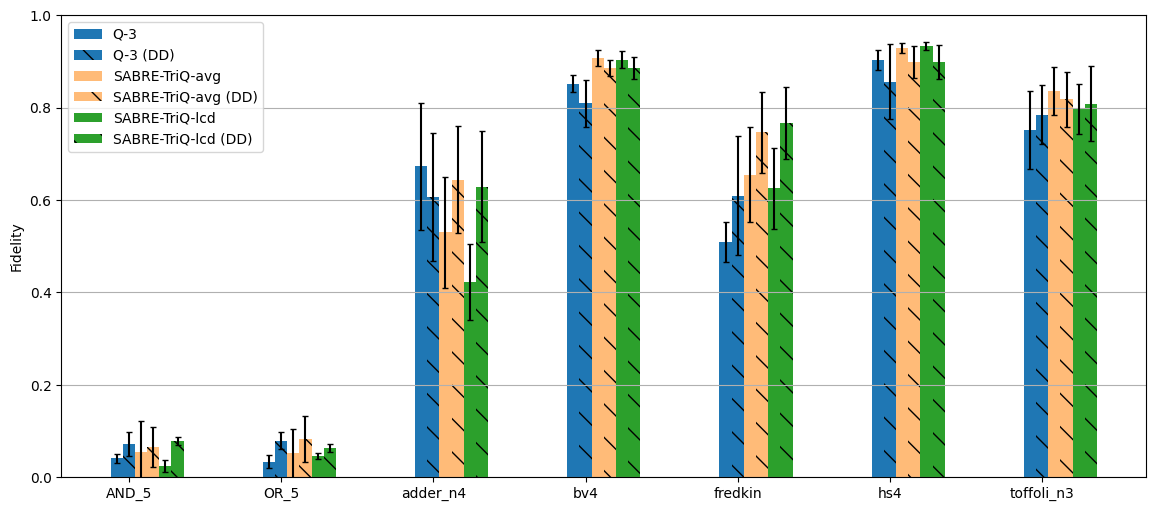

In [5]:
df_bris_cal = df_bris.loc[((df_bris['circuit_name'] == 'adder_n4') | (df_bris['circuit_name'] == 'AND_5')
| (df_bris['circuit_name'] == 'bv4') | (df_bris['circuit_name'] == 'fredkin')
| (df_bris['circuit_name'] == 'hs4') | (df_bris['circuit_name'] == 'OR_5')
| (df_bris['circuit_name'] == 'toffoli_n3')
                          )]

df_bris_cal_summary = df_bris_cal.groupby(['circuit_name', 'opt', "dd_enable"])['TVD'].agg(['mean', 'std']).reset_index()
df_bris_cal_circuits = df_bris_cal_summary['circuit_name'].unique()
opts = df_bris_cal_summary['opt'].unique()
#print(opts)
# legends = opts
opts = ['qiskit_3', 'sabre_triq_avg', 'sabre_triq_lcd']

legends = ["Q-3", "Q-3 (DD)","SABRE-TriQ-avg","SABRE-TriQ-avg (DD)", "SABRE-TriQ-lcd", "SABRE-TriQ-lcd (DD)"]
show_summary_bar_lines(df_bris_cal_summary, opts, legends, df_bris_cal_circuits, [0,1], "Fidelity", width=0.08, figsize=(14,6))

['bv_2' 'bv_3' 'bv_4' 'bv_5' 'bv_6' 'bv_7' 'bv_8' 'bv_9' 'bv_10' 'bv_11'
 'bv_12']


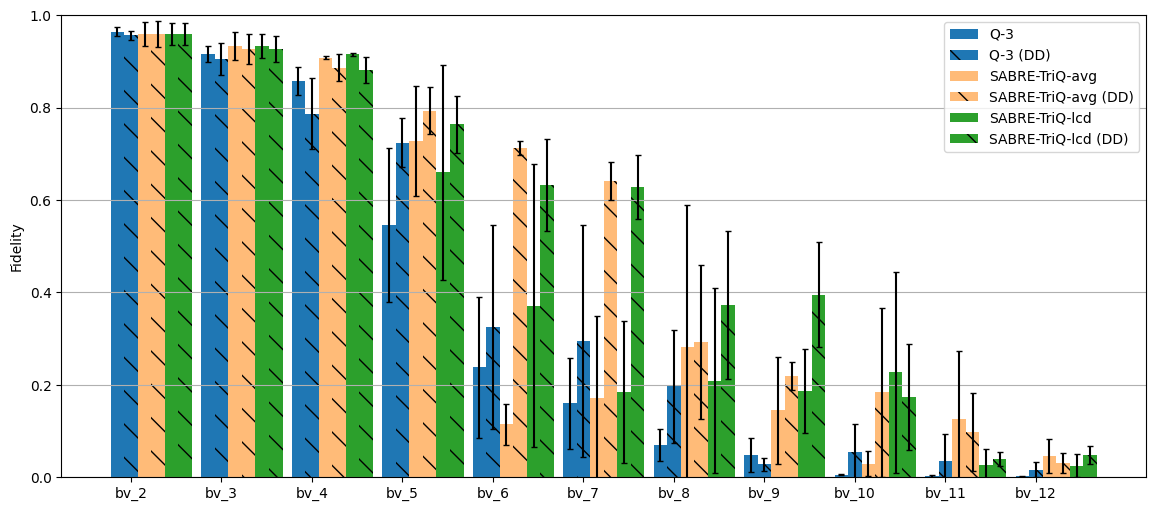

In [6]:
df_bris_bv = df_bris.loc[((df_bris['circuit_name'] == 'bv_2') | (df_bris['circuit_name'] == 'bv_3')
| (df_bris['circuit_name'] == 'bv_4') | (df_bris['circuit_name'] == 'bv_5') | (df_bris['circuit_name'] == 'bv_6')
| (df_bris['circuit_name'] == 'bv_7')| (df_bris['circuit_name'] == 'bv_8')| (df_bris['circuit_name'] == 'bv_9')
| (df_bris['circuit_name'] == 'bv_10')| (df_bris['circuit_name'] == 'bv_11')| (df_bris['circuit_name'] == 'bv_12')
                          )]

df_bris_bv_summary = df_bris_bv.groupby(['circuit_name', 'opt', "qubit", "dd_enable"])['TVD'].agg(['mean', 'std']).reset_index()
df_bris_bv_summary = df_bris_bv_summary.sort_values(by='qubit', ascending=True)

df_bris_bv_circuits = df_bris_bv_summary['circuit_name'].unique()
opts = df_bris_bv_summary['opt'].unique()

print(df_bris_bv_circuits)
# legends = opts
opts = ['qiskit_3', 'sabre_triq_avg', 'sabre_triq_lcd']

legends = ["Q-3", "Q-3 (DD)","SABRE-TriQ-avg","SABRE-TriQ-avg (DD)", "SABRE-TriQ-lcd", "SABRE-TriQ-lcd (DD)"]
show_summary_bar_lines(df_bris_bv_summary, opts, legends, df_bris_bv_circuits, [0,1], "Fidelity", width=0.15, figsize=(14,6))

['adder_n4' 'adder_n7' 'adder_n10']


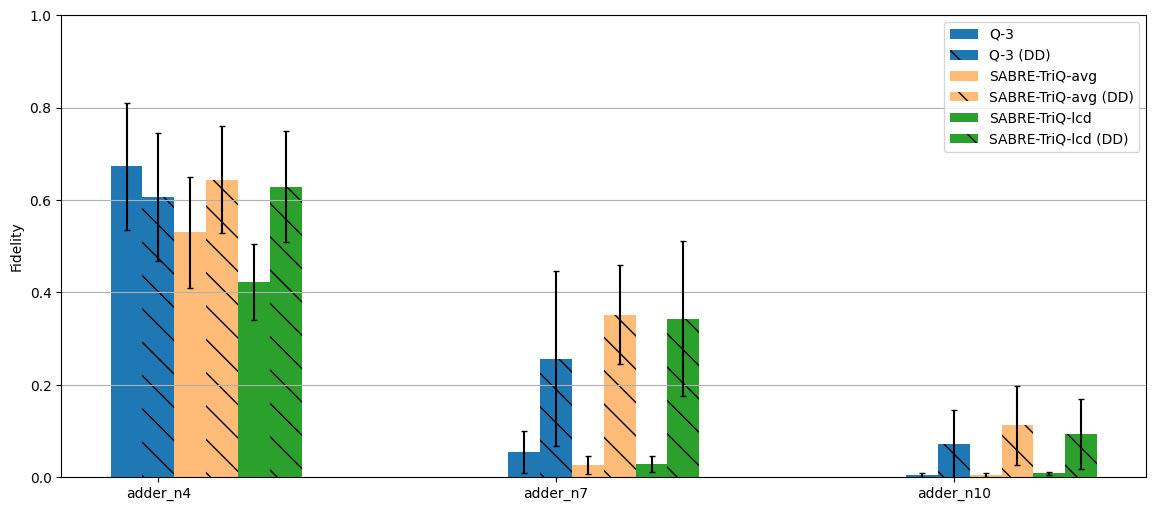

In [7]:
df_bris_add = df_bris.loc[((df_bris['circuit_name'] == 'adder_n4') | (df_bris['circuit_name'] == 'adder_n7')
| (df_bris['circuit_name'] == 'adder_n10') 
                          )]

df_bris_add_summary = df_bris_add.groupby(['circuit_name', 'opt', "qubit", "dd_enable"])['TVD'].agg(['mean', 'std']).reset_index()
df_bris_add_summary = df_bris_add_summary.sort_values(by='qubit', ascending=True)

df_bris_add_circuits = df_bris_add_summary['circuit_name'].unique()
opts = df_bris_add_summary['opt'].unique()

print(df_bris_add_circuits)
# legends = opts
opts = ['qiskit_3', 'sabre_triq_avg', 'sabre_triq_lcd']

legends = ["Q-3", "Q-3 (DD)","SABRE-TriQ-avg","SABRE-TriQ-avg (DD)", "SABRE-TriQ-lcd", "SABRE-TriQ-lcd (DD)"]
show_summary_bar_lines(df_bris_add_summary, opts, legends, df_bris_add_circuits, [0,1], "Fidelity", width=0.08, figsize=(14,6))

## Sherbrooke

In [18]:
df_sher = get_data_scale(3, "ibm_sherbrooke")
df_sher.head()

header_id circuit_name             opt  circuit_depth  \
0 2024-07-10 14:08:24         bv_2  sabre_triq_lcd           25.0   
1 2024-07-09 11:32:23         bv_2        qiskit_3           63.0   
2 2024-07-06 16:55:04         bv_2  sabre_triq_lcd           20.0   
3 2024-07-05 15:21:13         bv_2        qiskit_3           50.0   
4 2024-07-06 16:55:33         bv_2  sabre_triq_avg           20.0   

   qubit_gate_count_2q      TVD    quasi  qubit  dd_enable dd_seq_type  \
0                  1.0  0.97400  0.97400    2.0          1         XY4   
1                  1.0  0.97000  0.97000    2.0          1         XY4   
2                  1.0  0.94925  0.94925    2.0          0        None   
3                  1.0  0.96325  0.96325    2.0          0        None   
4                  1.0  0.95450  0.95450    2.0          1         XY4   

  dd_sch_method  
0          alap  
1          alap  
2          None  
3          None  
4          alap

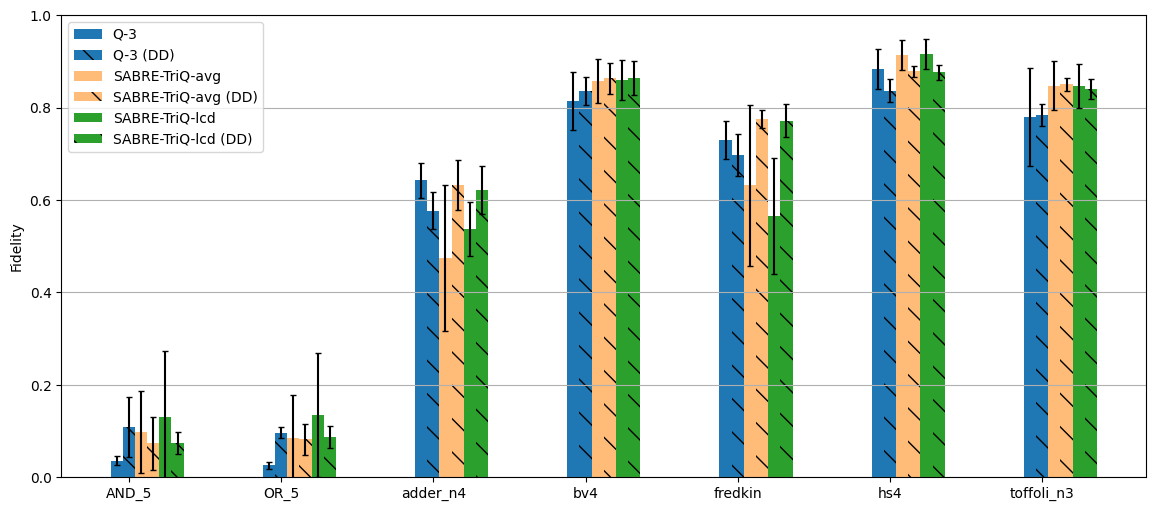

In [19]:
df_sher_cal = df_sher.loc[((df_sher['circuit_name'] == 'adder_n4') | (df_sher['circuit_name'] == 'AND_5')
| (df_sher['circuit_name'] == 'bv4') | (df_sher['circuit_name'] == 'fredkin')
| (df_sher['circuit_name'] == 'hs4') | (df_sher['circuit_name'] == 'OR_5')
| (df_sher['circuit_name'] == 'toffoli_n3')
                          )]

df_sher_cal_summary = df_sher_cal.groupby(['circuit_name', 'opt', "dd_enable"])['TVD'].agg(['mean', 'std']).reset_index()
df_sher_cal_circuits = df_sher_cal_summary['circuit_name'].unique()
opts = df_sher_cal_summary['opt'].unique()
#print(opts)
# legends = opts
opts = ['qiskit_3', 'sabre_triq_avg', 'sabre_triq_lcd']

legends = ["Q-3", "Q-3 (DD)","SABRE-TriQ-avg","SABRE-TriQ-avg (DD)", "SABRE-TriQ-lcd", "SABRE-TriQ-lcd (DD)"]
show_summary_bar_lines(df_sher_cal_summary, opts, legends, df_sher_cal_circuits, [0,1], "Fidelity", width=0.08, figsize=(14,6))

In [20]:
df_sher_cal_summary

circuit_name             opt  dd_enable      mean       std
0         AND_5        qiskit_3          0  0.035500  0.009507
1         AND_5        qiskit_3          1  0.107750  0.064798
2         AND_5  sabre_triq_avg          0  0.098250  0.088998
3         AND_5  sabre_triq_avg          1  0.073300  0.057873
4         AND_5  sabre_triq_lcd          0  0.130900  0.142024
5         AND_5  sabre_triq_lcd          1  0.074200  0.023819
6          OR_5        qiskit_3          0  0.025750  0.007523
7          OR_5        qiskit_3          1  0.096400  0.012164
8          OR_5  sabre_triq_avg          0  0.084550  0.094101
9          OR_5  sabre_triq_avg          1  0.082050  0.033204
10         OR_5  sabre_triq_lcd          0  0.134000  0.134555
11         OR_5  sabre_triq_lcd          1  0.087650  0.023527
12     adder_n4        qiskit_3          0  0.642550  0.037908
13     adder_n4        qiskit_3          1  0.576545  0.040200
14     adder_n4  sabre_triq_avg          0  0.473750  0.157831
15     adder_n4  sabre_triq_avg          1  0.632500  0.053516
16     adder_n4  sabre_triq_lcd          0  0.537400  0.057942
17     adder_n4  sabre_triq_lcd          1  0.621114  0.051863
18          bv4        qiskit_3          0  0.813400  0.062613
19          bv4        qiskit_3          1  0.836050  0.030707
20          bv4  sabre_triq_avg          0  0.857250  0.047294
21          bv4  sabre_triq_avg          1  0.863250  0.034004
22          bv4  sabre_triq_lcd          0  0.859550  0.043551
23          bv4  sabre_triq_lcd          1  0.864250  0.036375
24      fredkin        qiskit_3          0  0.729100  0.040738
25      fredkin        qiskit_3          1  0.697600  0.045899
26      fredkin  sabre_triq_avg          0  0.631700  0.174457
27      fredkin  sabre_triq_avg          1  0.774900  0.019395
28      fredkin  sabre_triq_lcd          0  0.565350  0.125498
29      fredkin  sabre_triq_lcd          1  0.771500  0.036020
30          hs4        qiskit_3          0  0.883450  0.043046
31          hs4        qiskit_3          1  0.836550  0.024981
32          hs4  sabre_triq_avg          0  0.914700  0.032430
33          hs4  sabre_triq_avg          1  0.878200  0.012443
34          hs4  sabre_triq_lcd          0  0.915750  0.031789
35          hs4  sabre_triq_lcd          1  0.876400  0.016376
36   toffoli_n3        qiskit_3          0  0.779200  0.105613
37   toffoli_n3        qiskit_3          1  0.784500  0.024175
38   toffoli_n3  sabre_triq_avg          0  0.847200  0.053127
39   toffoli_n3  sabre_triq_avg          1  0.850000  0.014544
40   toffoli_n3  sabre_triq_lcd          0  0.847250  0.047538
41   toffoli_n3  sabre_triq_lcd          1  0.840050  0.020962

['bv_2' 'bv_3' 'bv_4' 'bv_5' 'bv_6' 'bv_7' 'bv_8' 'bv_9' 'bv_10' 'bv_11'
 'bv_12']


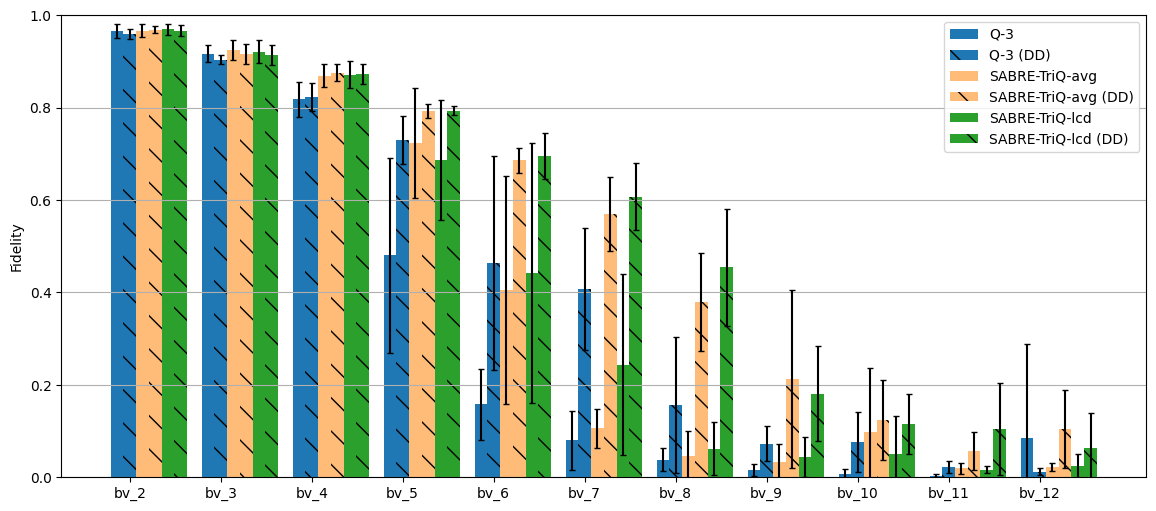

In [21]:
df_sher_bv = df_sher.loc[((df_sher['circuit_name'] == 'bv_2') | (df_sher['circuit_name'] == 'bv_3')
| (df_sher['circuit_name'] == 'bv_4') | (df_sher['circuit_name'] == 'bv_5') | (df_sher['circuit_name'] == 'bv_6')
| (df_sher['circuit_name'] == 'bv_7')| (df_sher['circuit_name'] == 'bv_8')| (df_sher['circuit_name'] == 'bv_9')
| (df_sher['circuit_name'] == 'bv_10')| (df_sher['circuit_name'] == 'bv_11')| (df_sher['circuit_name'] == 'bv_12')
                          )]

df_sher_bv_summary = df_sher_bv.groupby(['circuit_name', 'opt', "qubit", "dd_enable"])['TVD'].agg(['mean', 'std']).reset_index()
df_sher_bv_summary = df_sher_bv_summary.sort_values(by='qubit', ascending=True)

df_sher_bv_circuits = df_sher_bv_summary['circuit_name'].unique()
opts = df_sher_bv_summary['opt'].unique()

print(df_sher_bv_circuits)
# legends = opts
opts = ['qiskit_3', 'sabre_triq_avg', 'sabre_triq_lcd']

legends = ["Q-3", "Q-3 (DD)","SABRE-TriQ-avg","SABRE-TriQ-avg (DD)", "SABRE-TriQ-lcd", "SABRE-TriQ-lcd (DD)"]
show_summary_bar_lines(df_sher_bv_summary, opts, legends, df_sher_bv_circuits, [0,1], "Fidelity", width=0.14, figsize=(14,6))

['adder_n4' 'adder_n7' 'adder_n10']


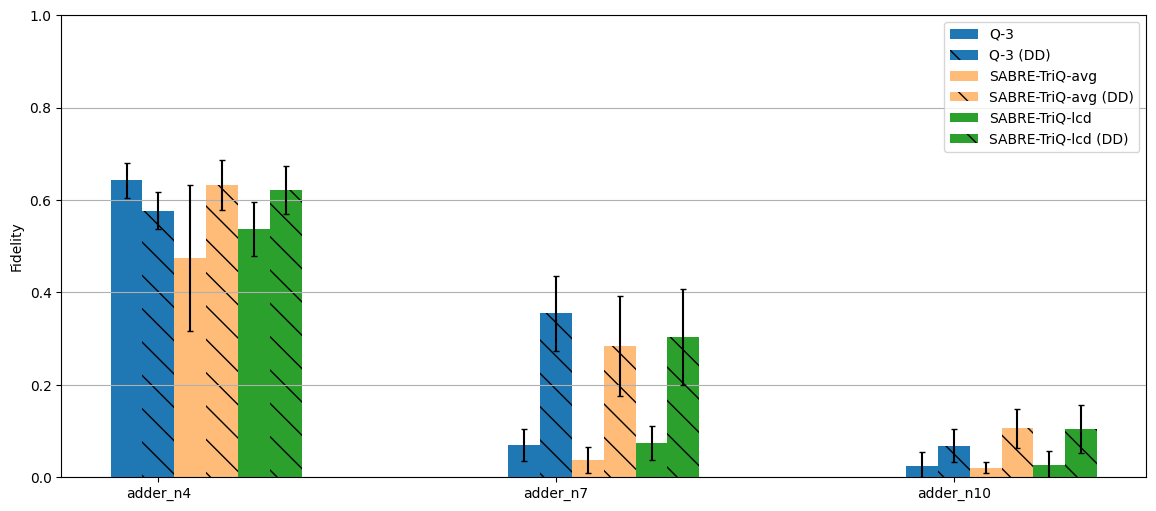

In [22]:
df_sher_add = df_sher.loc[((df_sher['circuit_name'] == 'adder_n4') | (df_sher['circuit_name'] == 'adder_n7')
| (df_sher['circuit_name'] == 'adder_n10') 
                          )]

df_sher_add_summary = df_sher_add.groupby(['circuit_name', 'opt', "qubit", "dd_enable"])['TVD'].agg(['mean', 'std']).reset_index()
df_sher_add_summary = df_sher_add_summary.sort_values(by='qubit', ascending=True)

df_sher_add_circuits = df_sher_add_summary['circuit_name'].unique()
opts = df_sher_add_summary['opt'].unique()

print(df_sher_add_circuits)
# legends = opts
opts = ['qiskit_3', 'sabre_triq_avg', 'sabre_triq_lcd']

legends = ["Q-3", "Q-3 (DD)","SABRE-TriQ-avg","SABRE-TriQ-avg (DD)", "SABRE-TriQ-lcd", "SABRE-TriQ-lcd (DD)"]
show_summary_bar_lines(df_sher_add_summary, opts, legends, df_sher_add_circuits, [0,1], "Fidelity", width=0.08, figsize=(14,6))

adder 7 without DD


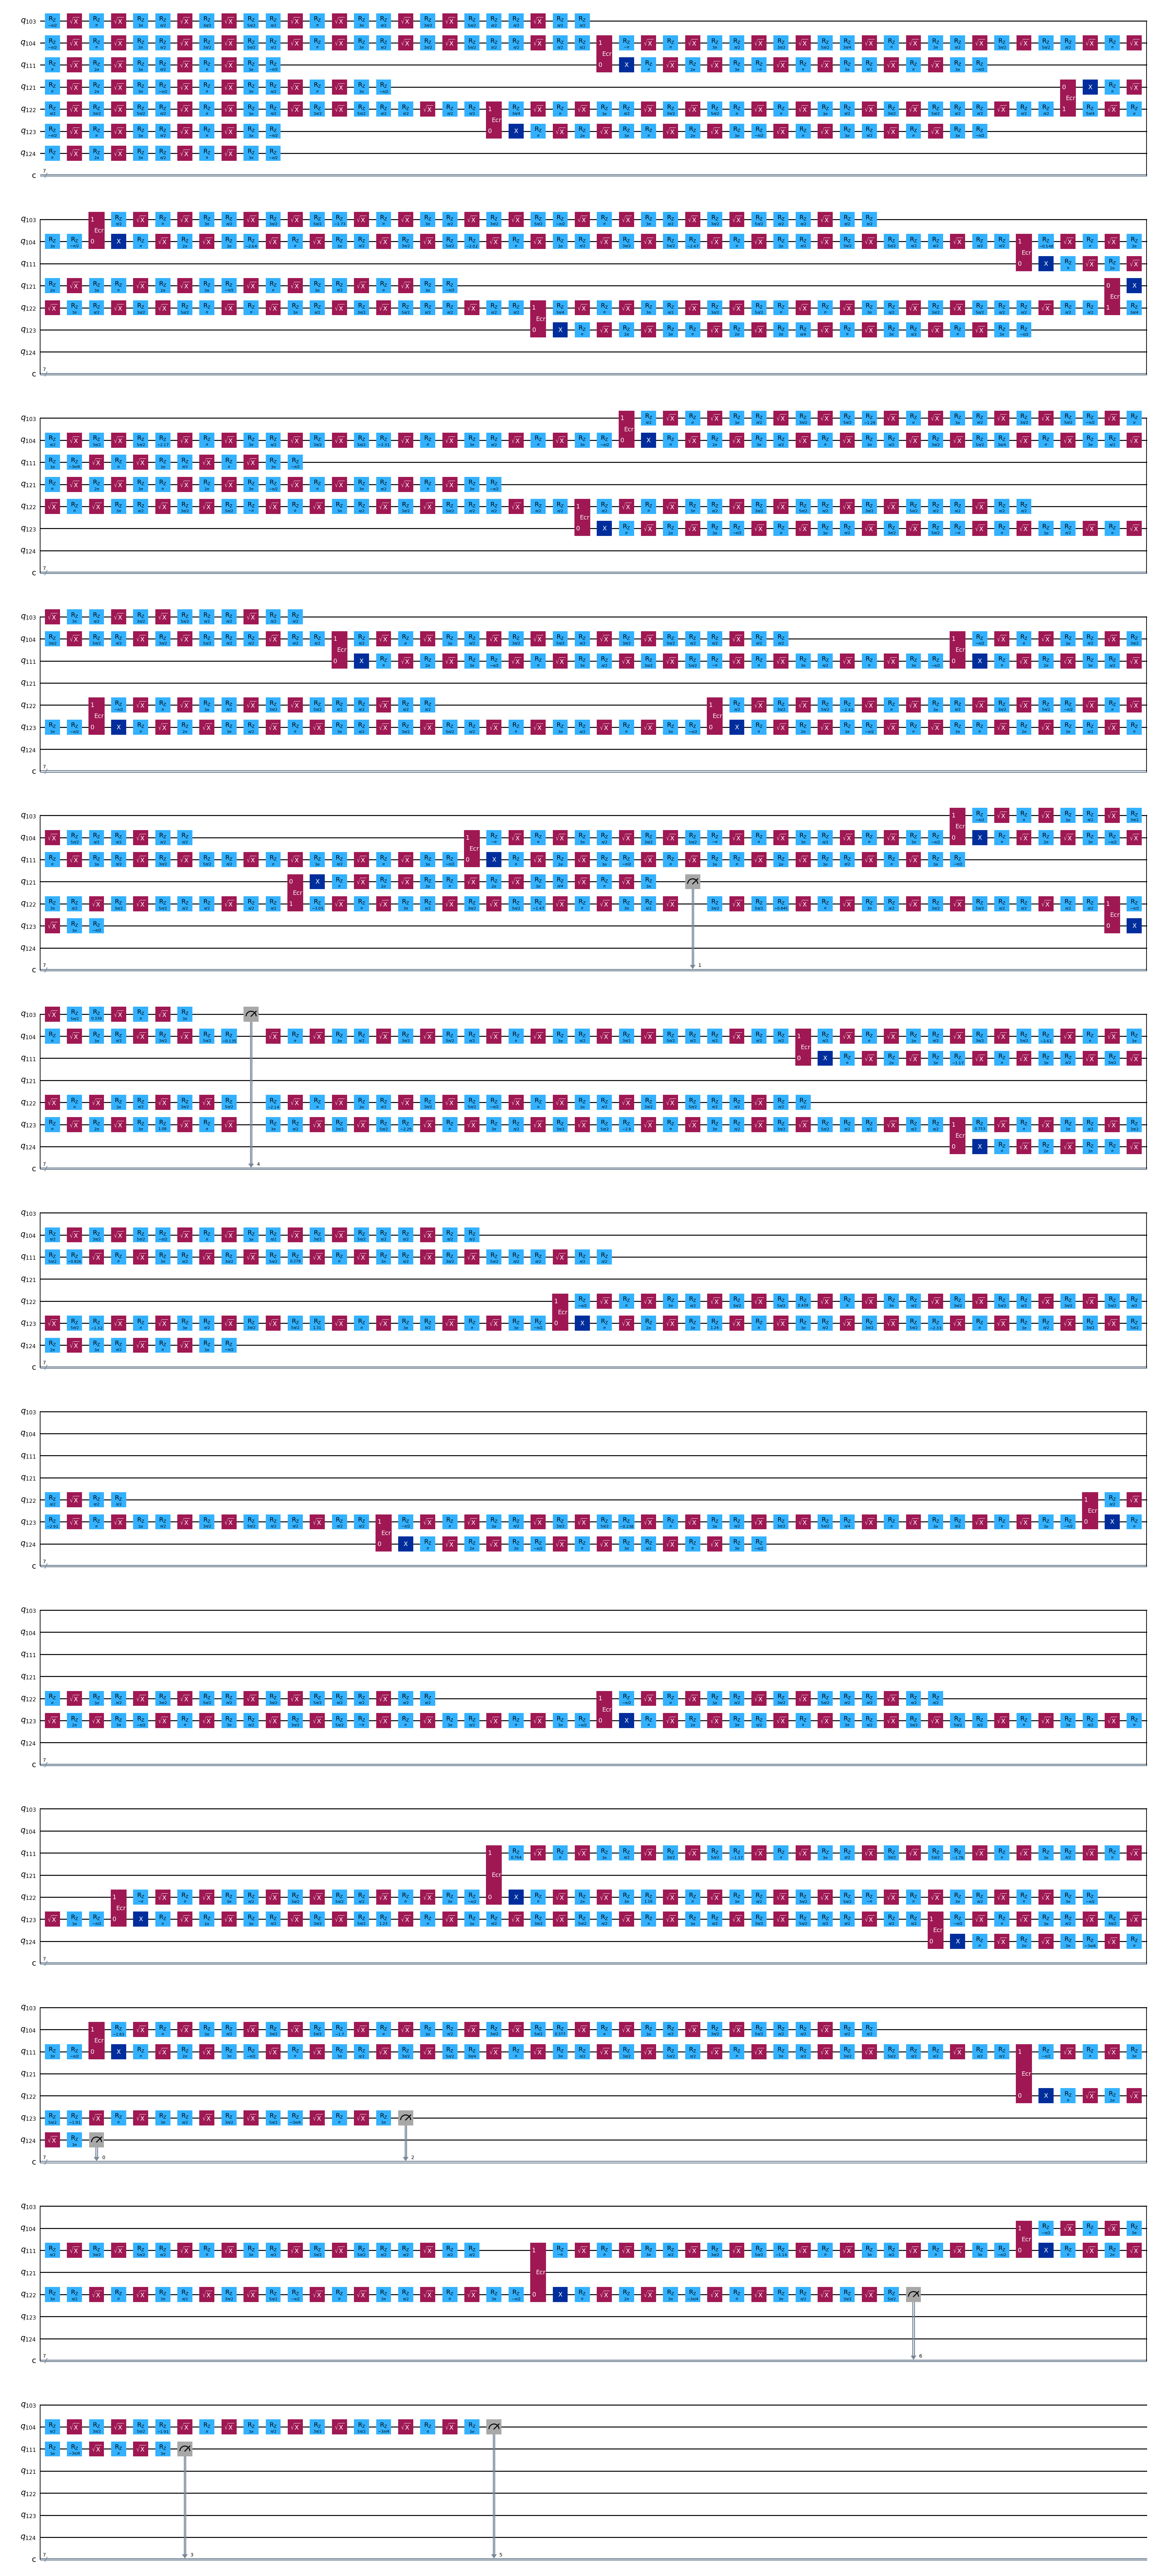

In [23]:
print("adder 7 without DD")
adder_n7 = QuantumCircuit.from_qasm_file("compiled/adder_n7_q3.qasm")
adder_n7.draw("mpl", idle_wires=False, fold=50)

adder_n7 - qiskit 3 - with DD XY4 alap


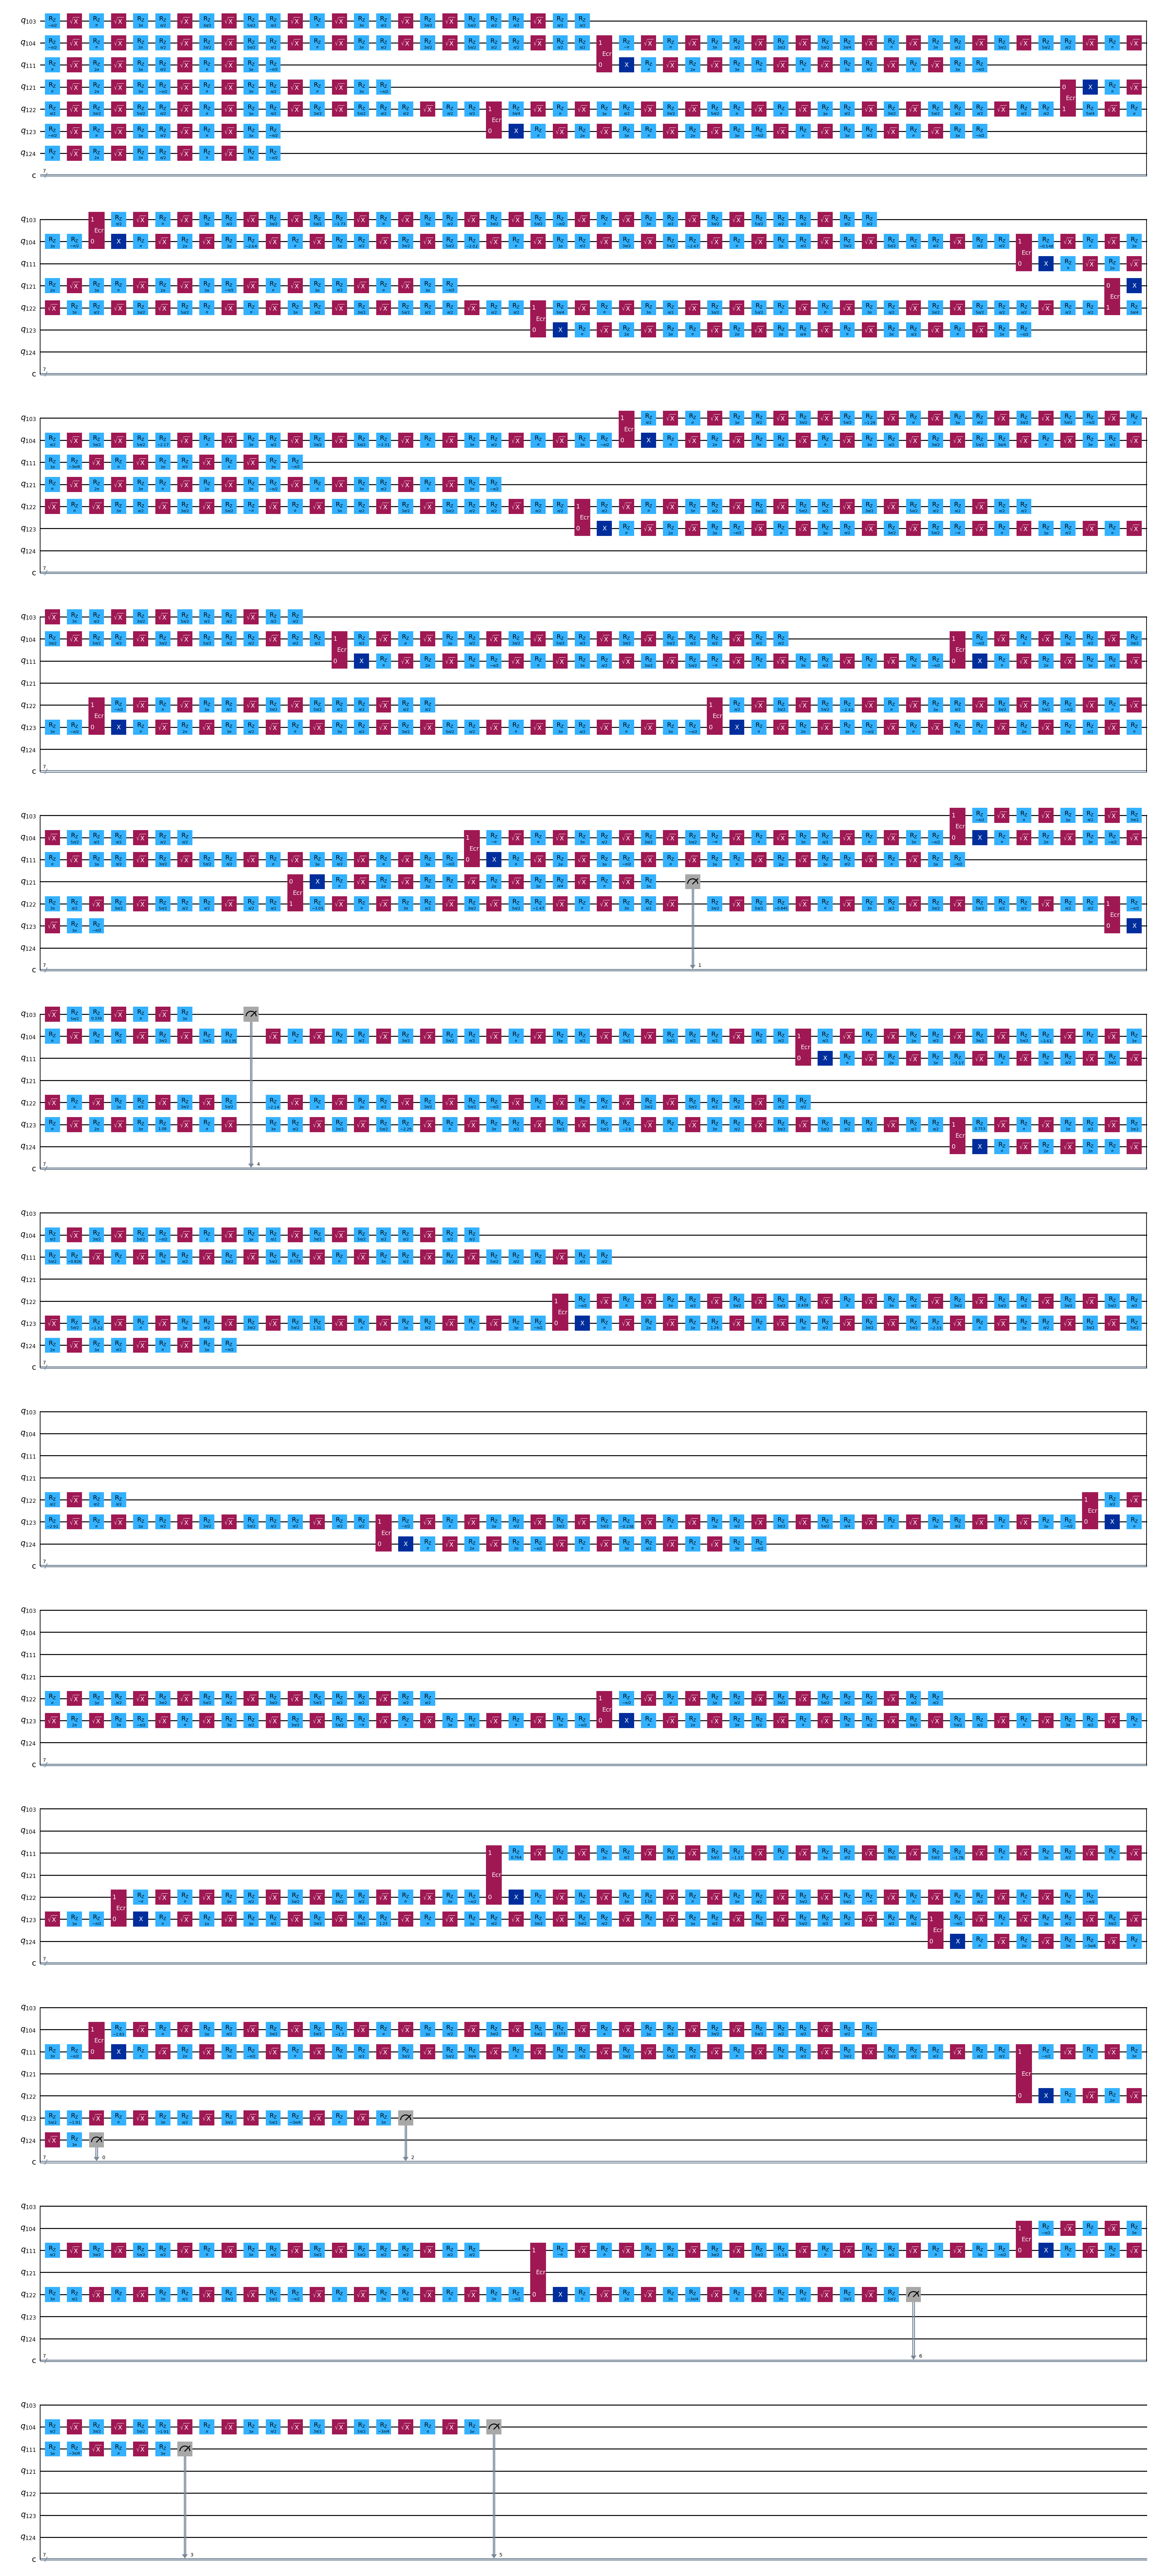

In [14]:
print("adder_n7 - qiskit 3 - with DD XY4 alap")
adder_n7 = QuantumCircuit.from_qasm_file("compiled/adder_n7_q3_dd.qasm")
adder_n7.draw("mpl", idle_wires=False, fold=50)

OR 5 - qiskit 3 - with DD XY4 alap


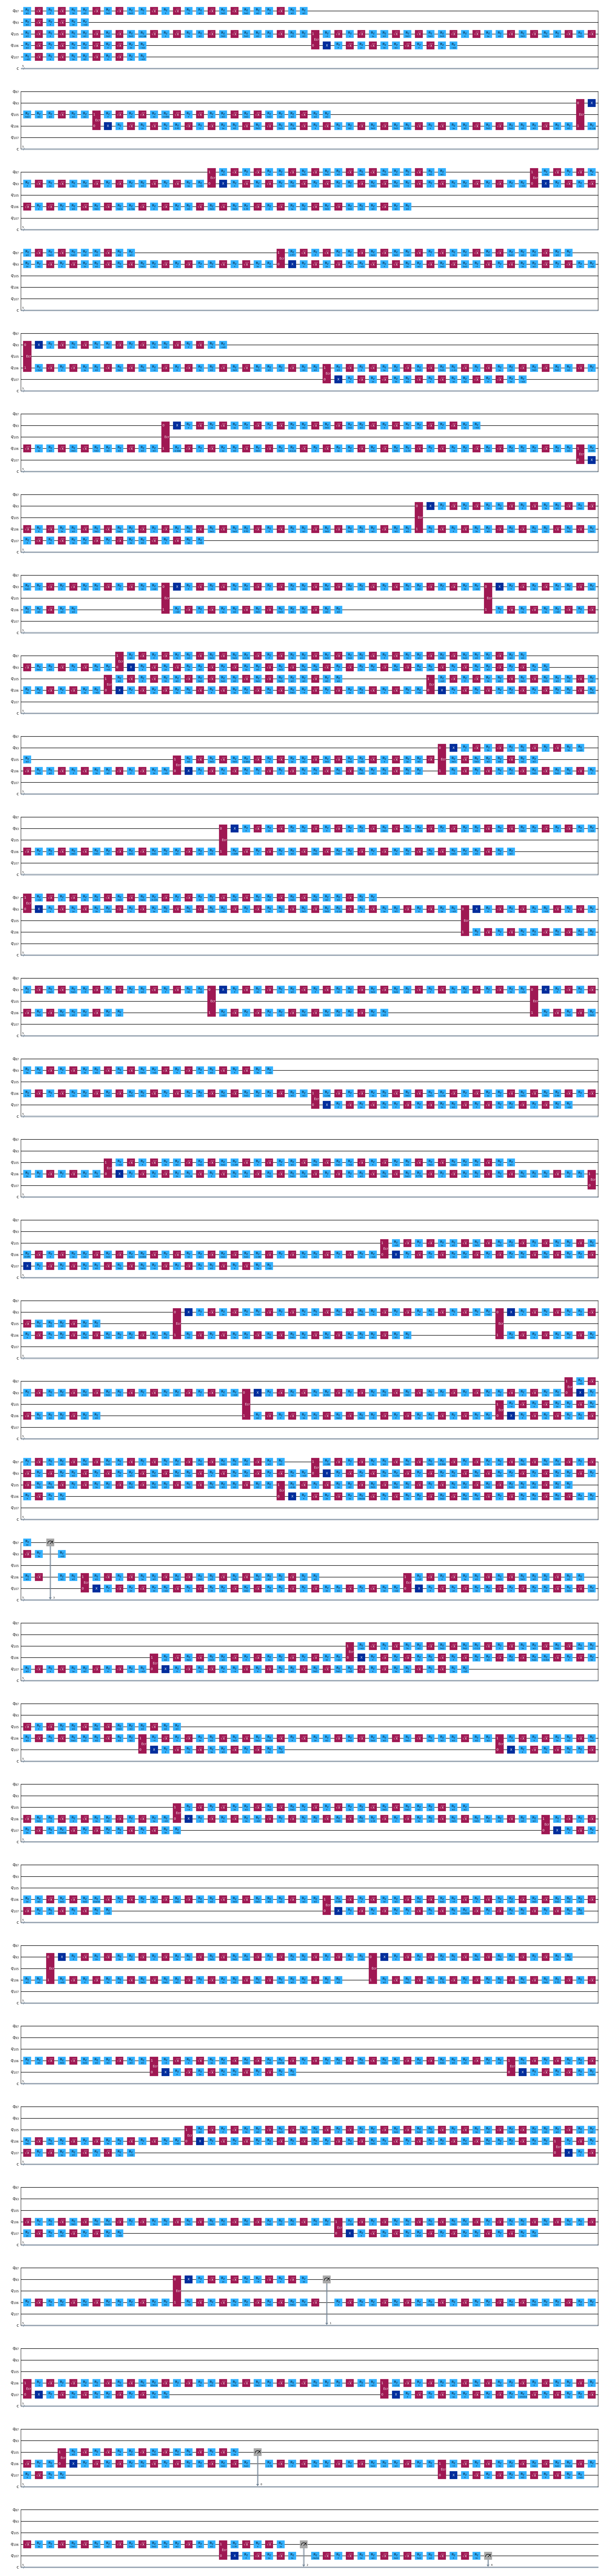

In [15]:
print("OR 5 - qiskit 3 - with DD XY4 alap")
adder_n7 = QuantumCircuit.from_qasm_file("compiled/OR_5_q3.qasm")
adder_n7.draw("mpl", idle_wires=False, fold=50)

HS 4 - qiskit 3 - with DD XY4 alap


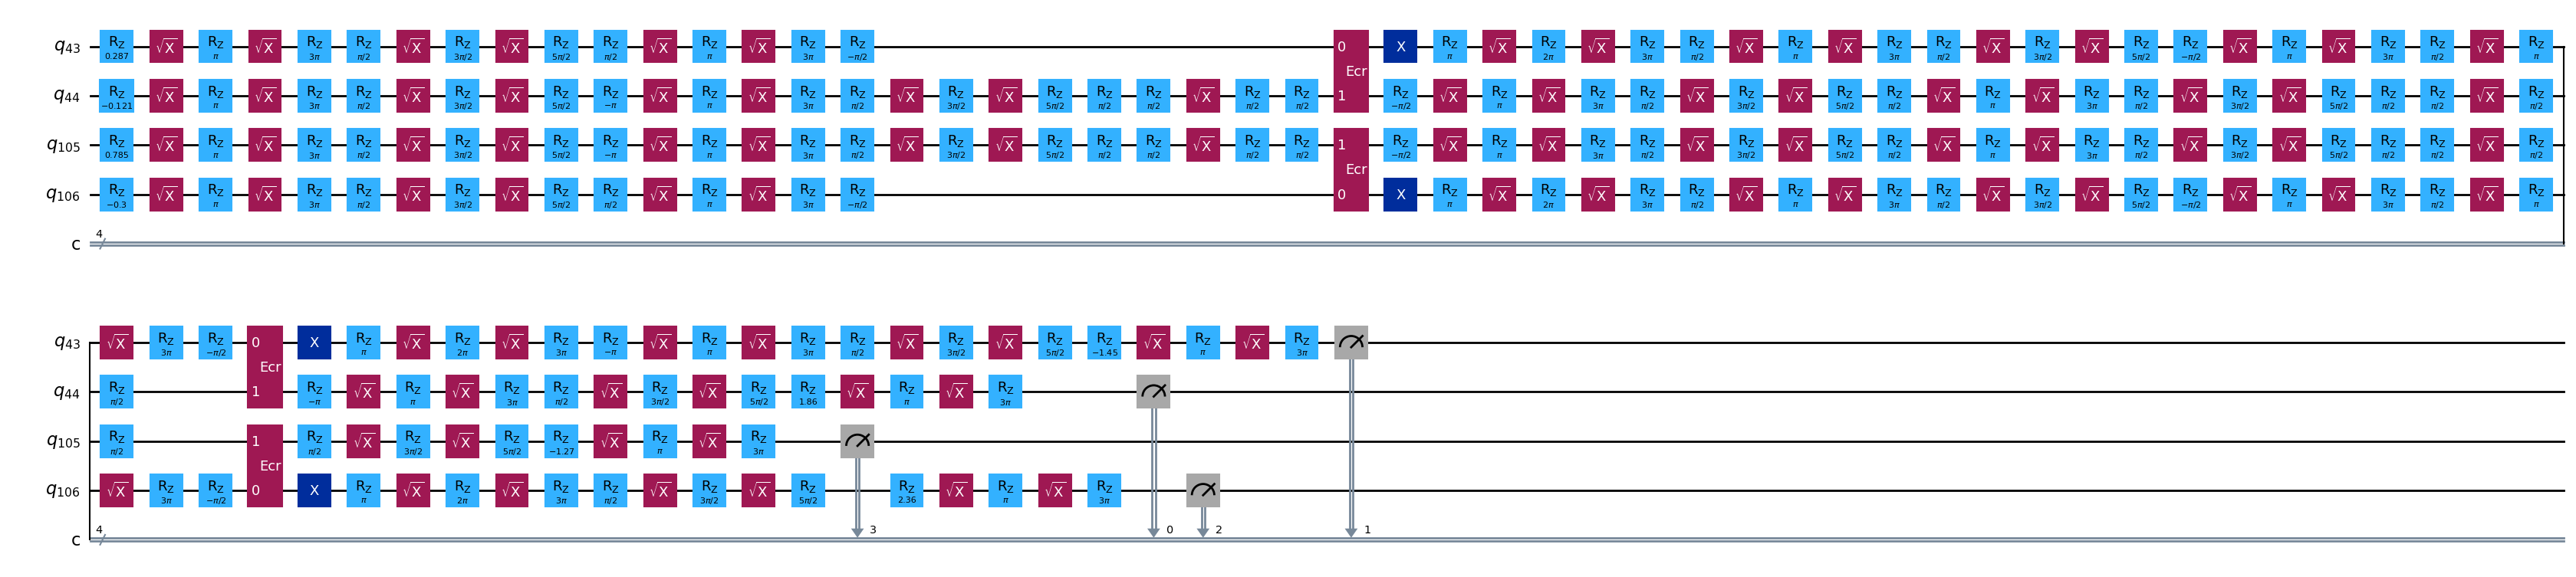

In [16]:
print("HS 4 - qiskit 3 - with DD XY4 alap")
adder_n7 = QuantumCircuit.from_qasm_file("compiled/hs_4_q3.qasm")
adder_n7.draw("mpl", idle_wires=False, fold=50)

Adder 4 - Triq


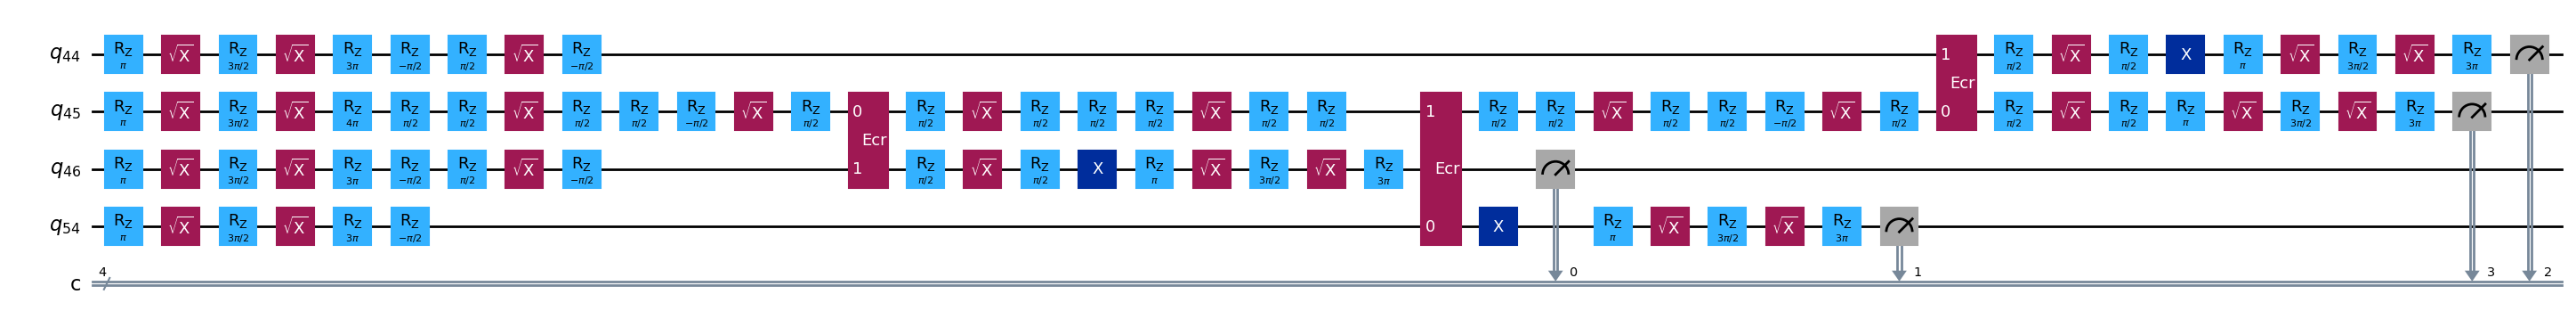

In [17]:
print("Adder 4 - Triq")
adder_n7 = QuantumCircuit.from_qasm_file("compiled/adder_n4_triq.qasm")
adder_n7.draw("mpl", idle_wires=False, fold=50)

Adder 4 - qiskit 3


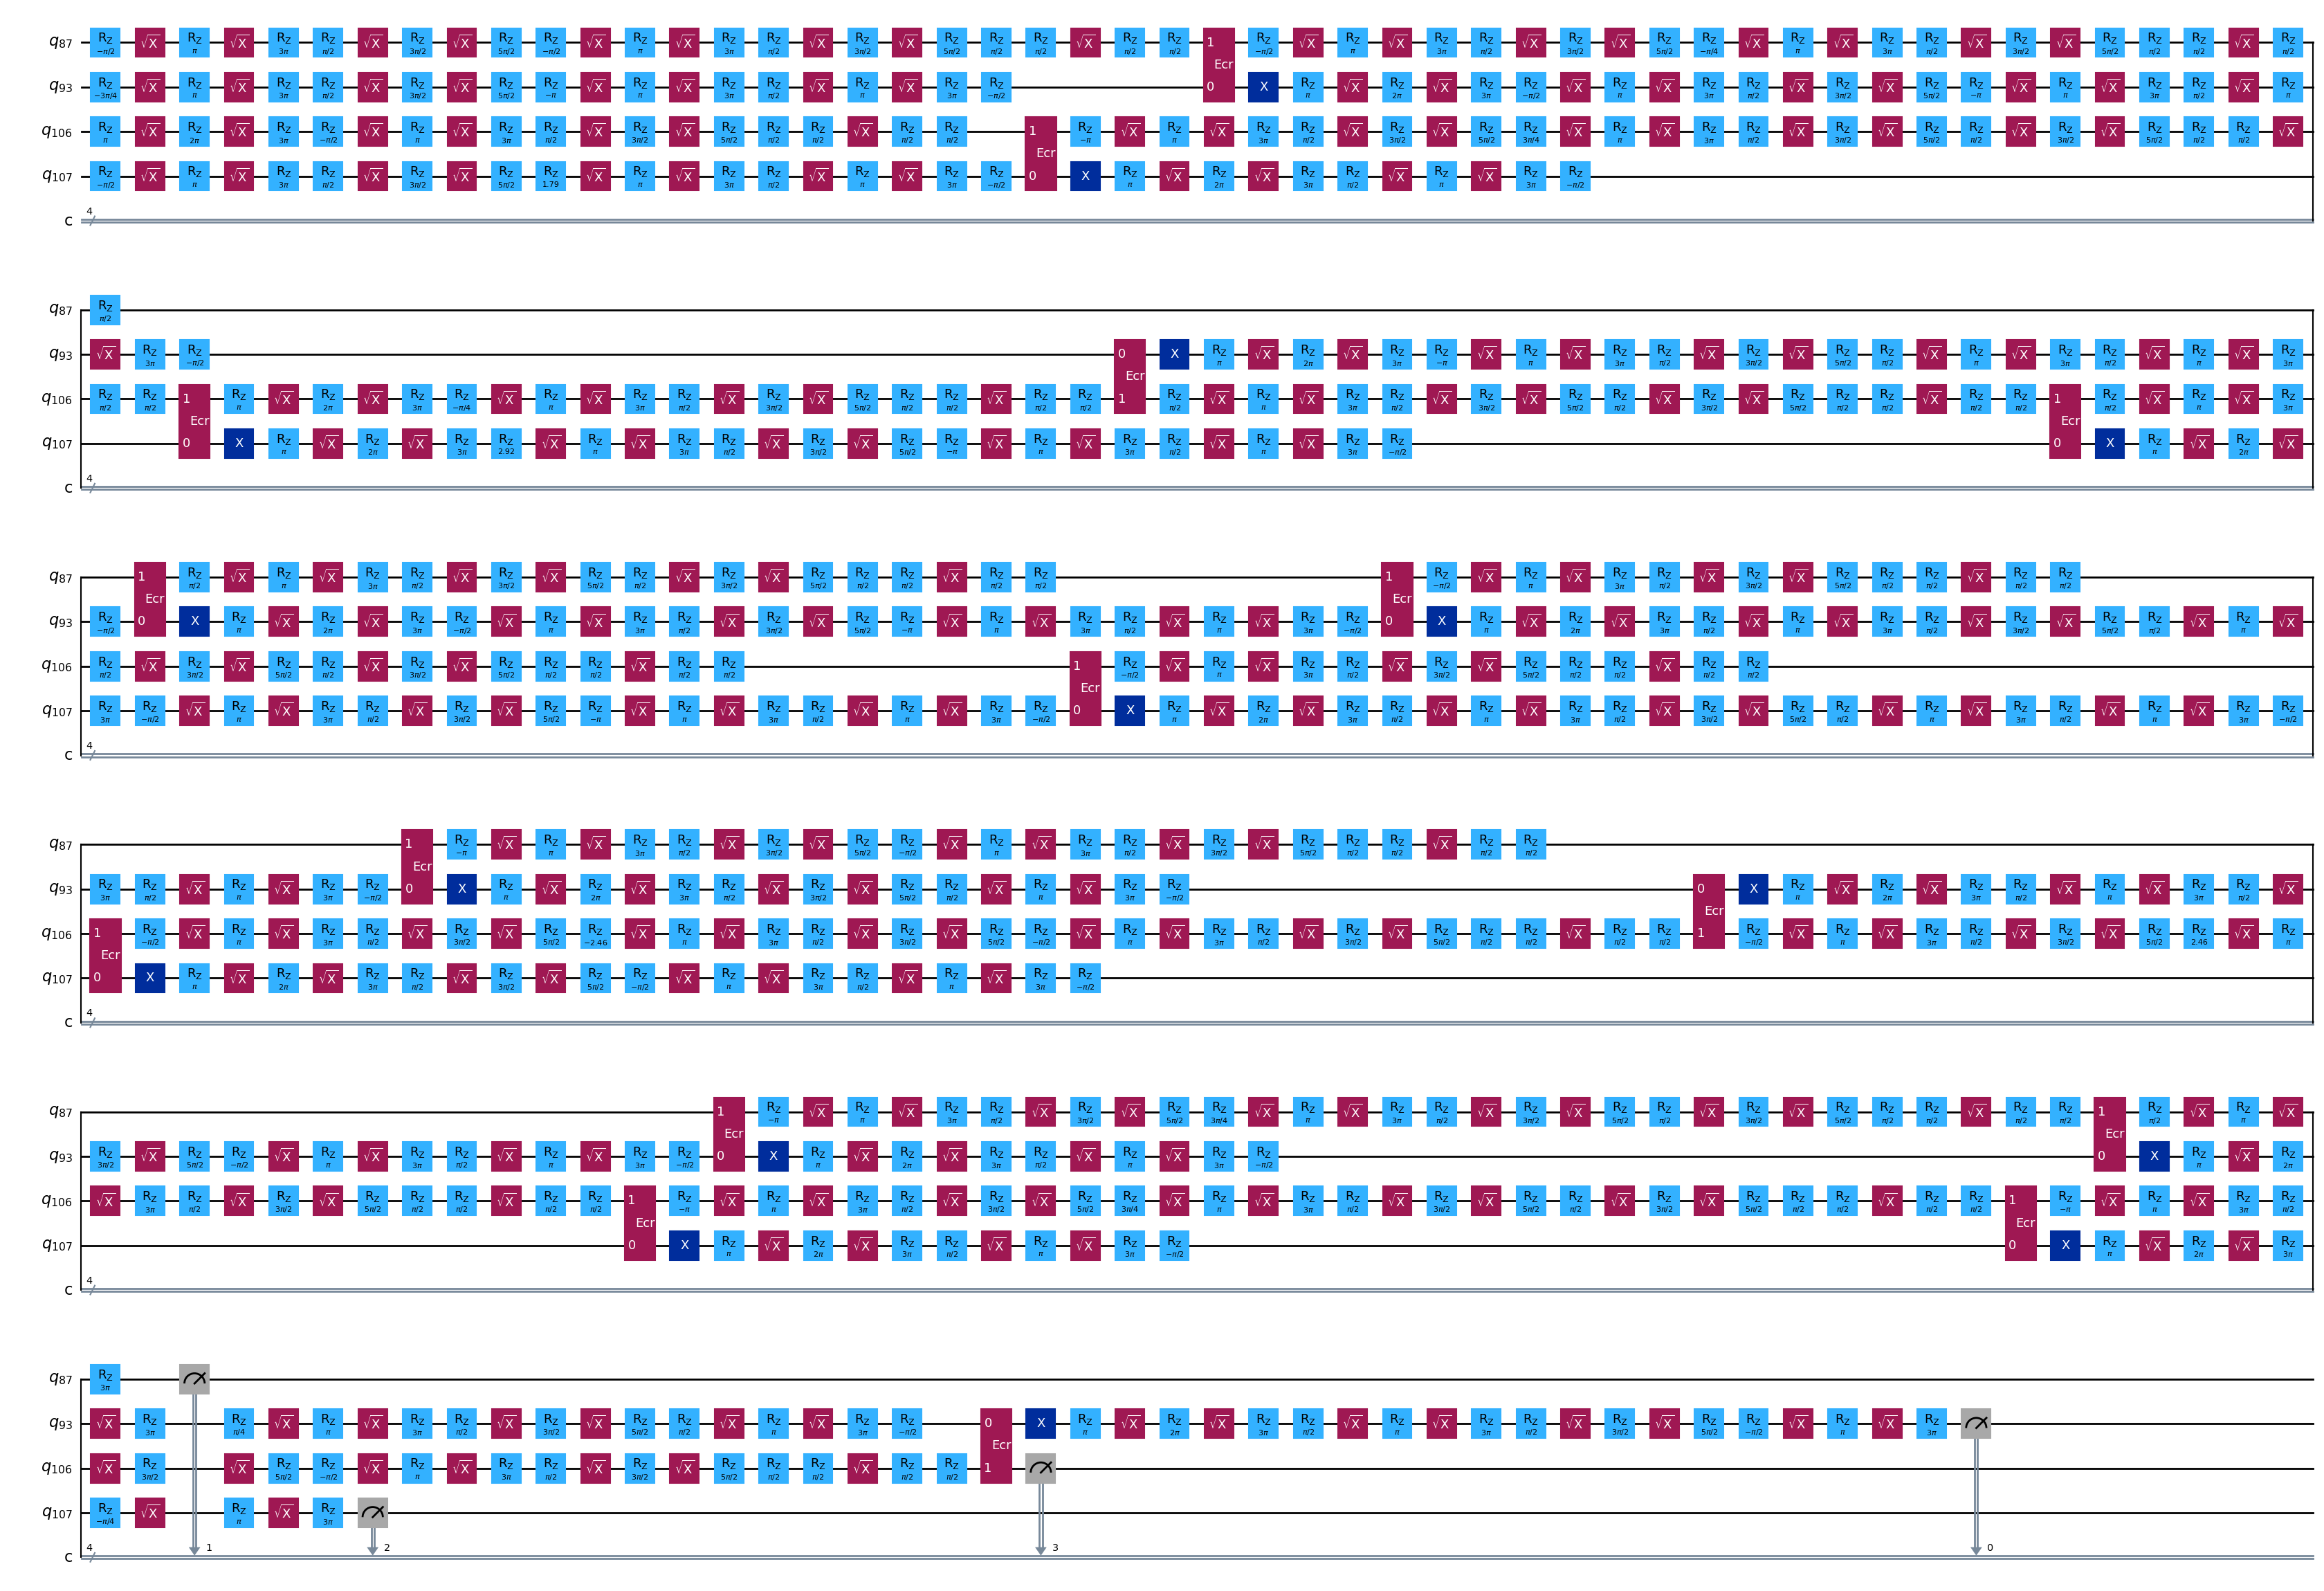

In [43]:
print("Adder 4 - qiskit 3")
adder_n7 = QuantumCircuit.from_qasm_file("compiled/adder_n4_q3.qasm")
adder_n7.draw("mpl", idle_wires=False, fold=50)

Adder 4 - qiskit 3


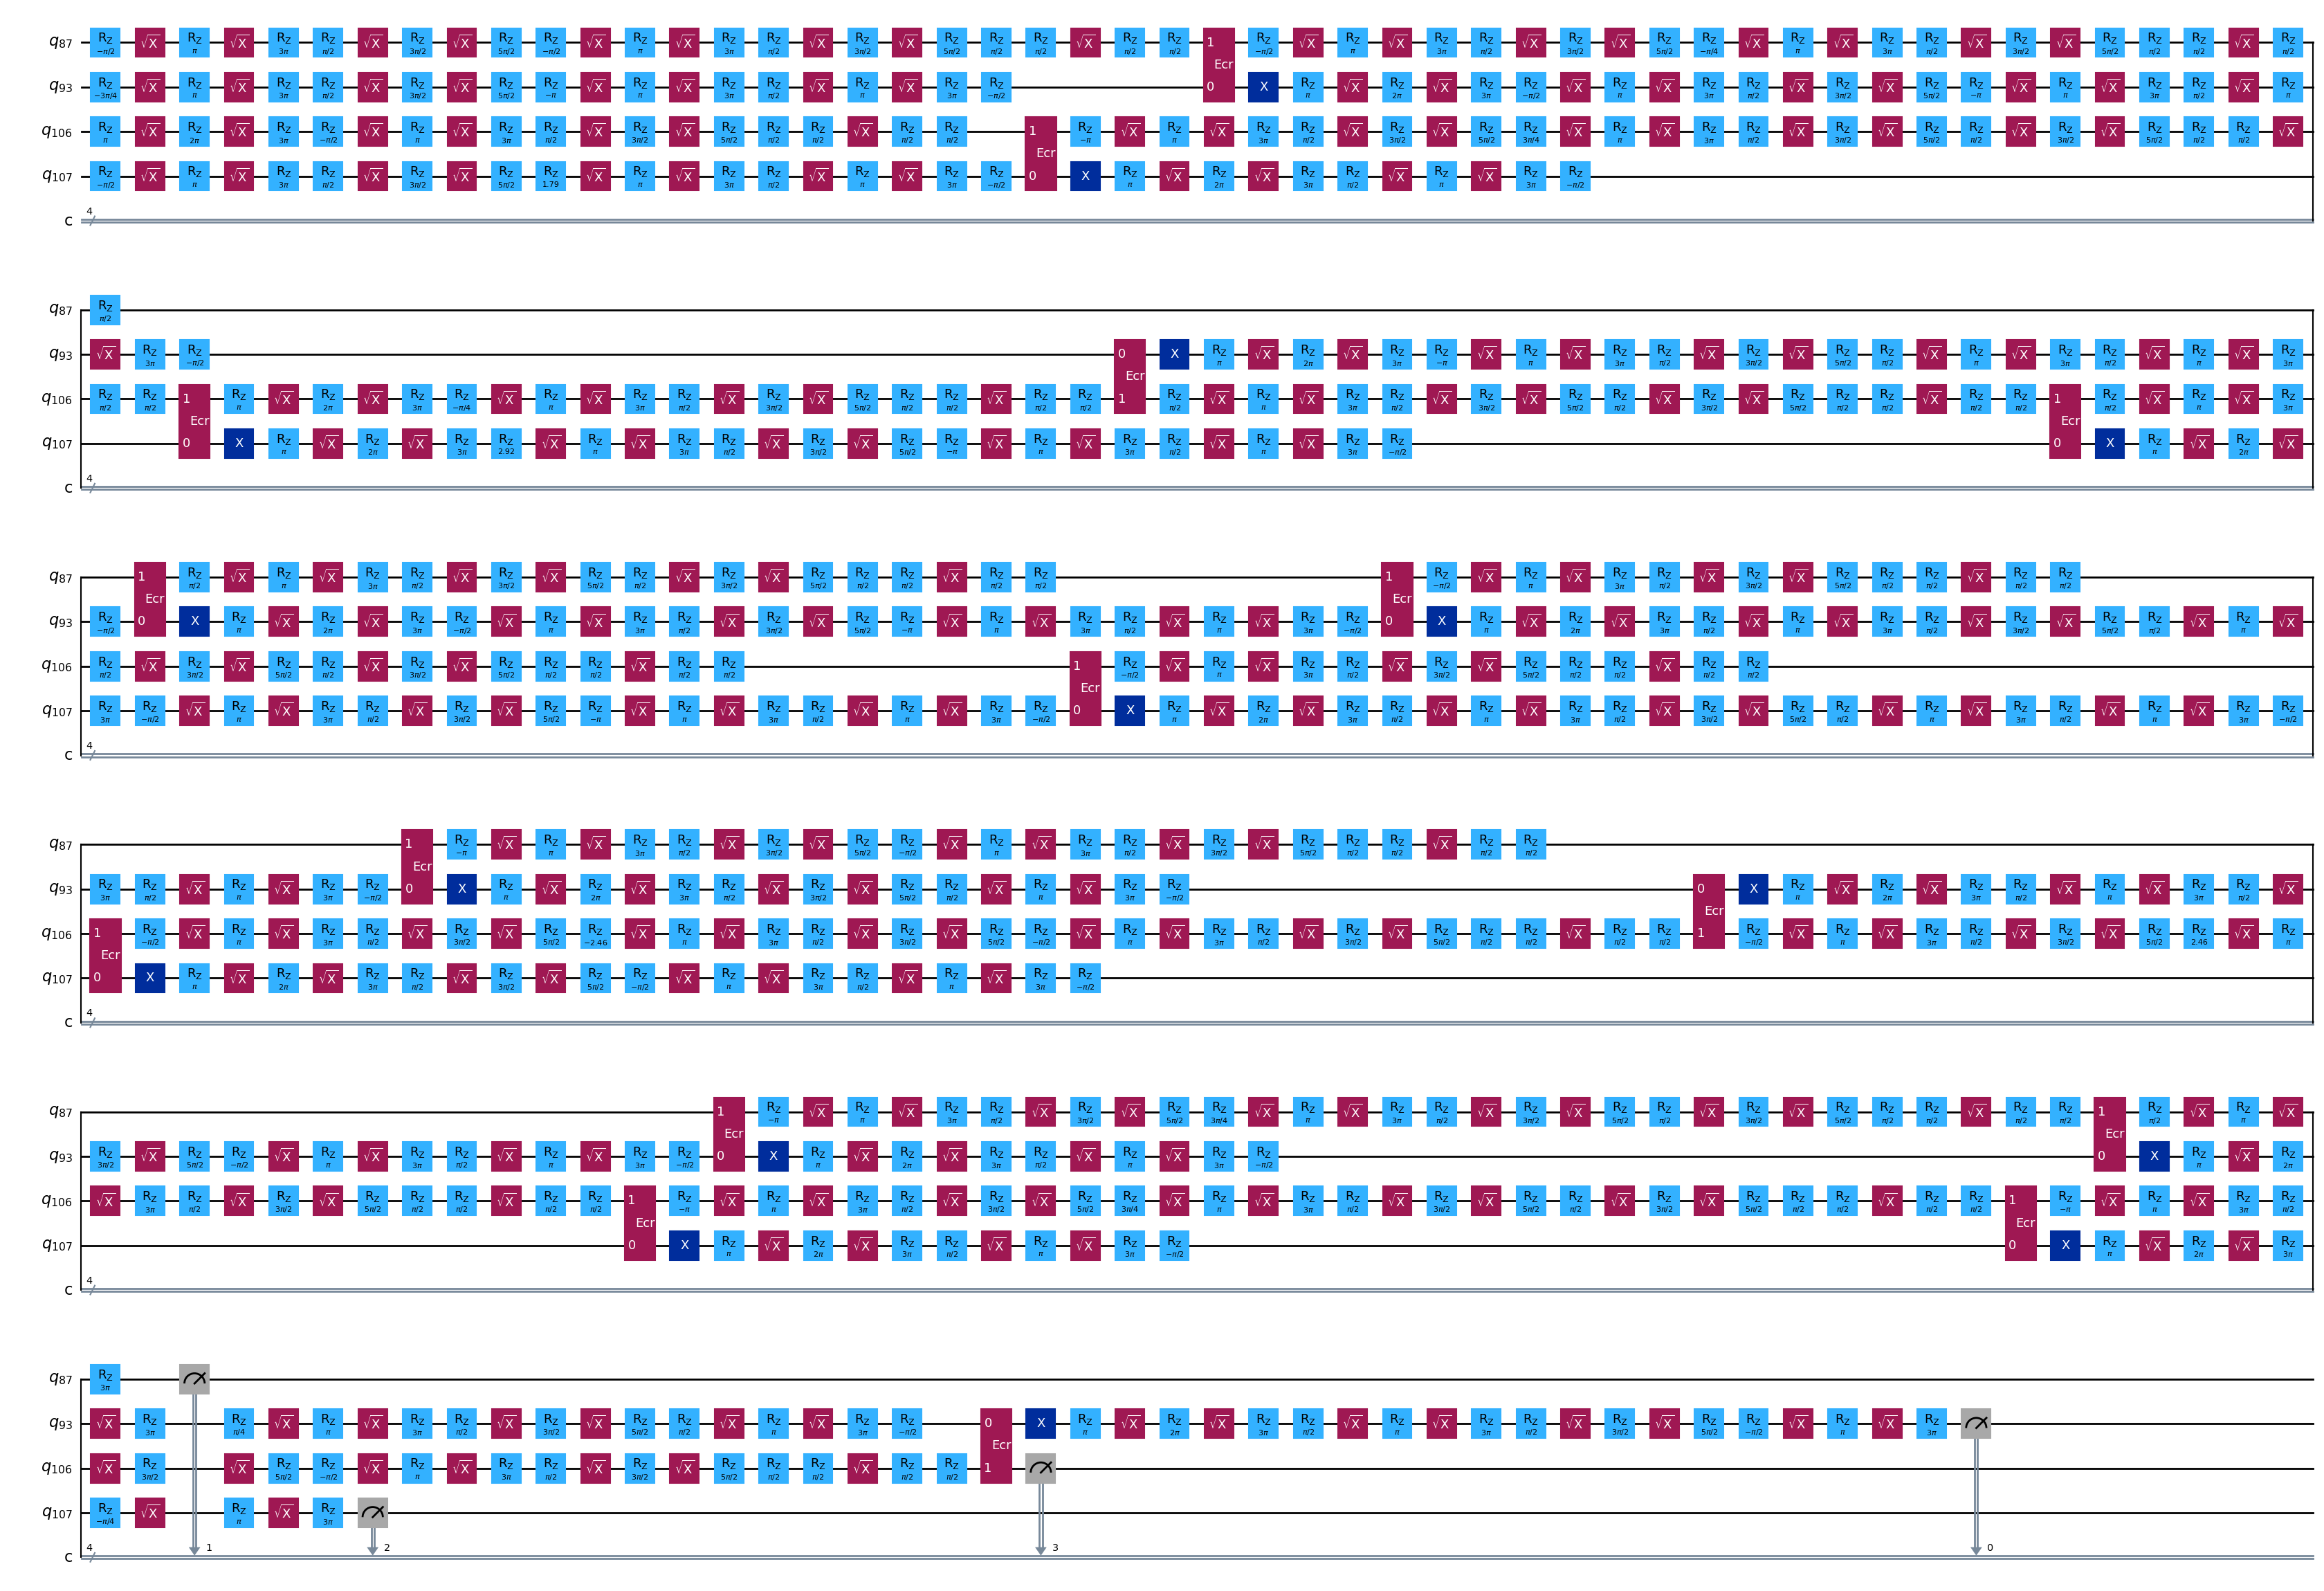

In [44]:
print("Adder 4 - qiskit 3")
adder_n7 = QuantumCircuit.from_qasm_file("compiled/adder_n4_q3_dd.qasm")
adder_n7.draw("mpl", idle_wires=False, fold=50)

In [98]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token='1d450995bf537145e23d54d7d7a6f1f49c07b411e5d0aefc87f1fdbe7f47a4ee24f7812e6225998f59505542098fee89630ada38da0cb1699a1d64ed6f42b081'
)
job_dd = service.job('ct5vkk6mqj7g0080nz0g')
job_result_dd = job_dd.result()

# To get counts for a particular pub result, use 
#
pub_result_dd = job_result_dd[0].data.c.get_counts()

#
# where <idx> is the index of the pub and <classical register> is the name of the classical register. 
# You can use circuit.cregs to find the name of the classical registers.

In [99]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token='1d450995bf537145e23d54d7d7a6f1f49c07b411e5d0aefc87f1fdbe7f47a4ee24f7812e6225998f59505542098fee89630ada38da0cb1699a1d64ed6f42b081'
)
job = service.job('ct5vkkemqj7g0080nz10')
job_result = job.result()

# To get counts for a particular pub result, use 
#
pub_result = job_result[0].data.c.get_counts()
#
# where <idx> is the index of the pub and <classical register> is the name of the classical register. 
# You can use circuit.cregs to find the name of the classical registers.

In [100]:
for i in range(3):
    result_dd = convert_dict_binary_to_int(job_result_dd[i].data.c.get_counts())["123"]
    result = convert_dict_binary_to_int(job_result[i].data.c.get_counts())["123"]
    
    print("DD :", result_dd, ", normal :", result)

DD : 1273 , normal : 526
DD : 1043 , normal : 177
DD : 1010 , normal : 126


In [105]:
for i in range(3, 6):
    result_dd = convert_dict_binary_to_int(job_result_dd[i].data.c.get_counts())["9"]
    result = convert_dict_binary_to_int(job_result[i].data.c.get_counts())["9"]
    
    print("DD :", result_dd, ", normal :", result)

DD : 2318 , normal : 2504
DD : 2751 , normal : 2139
DD : 2743 , normal : 2154


In [107]:
for i in range(6, 9):
    result_dd = convert_dict_binary_to_int(job_result_dd[i].data.c.get_counts())["1019"]
    result = convert_dict_binary_to_int(job_result[i].data.c.get_counts())["1019"]
    
    print("DD :", result_dd, ", normal :", result)

DD : 337 , normal : 67
DD : 690 , normal : 89
DD : 337 , normal : 3


In [101]:
print(pub_result_dd["1111011"], pub_result["1111011"])

1273 526


In [89]:
job_dd.inputs["options"]

{'default_shots': 4000,
 'dynamical_decoupling': {'enable': True,
  'sequence_type': 'XY4',
  'scheduling_method': 'alap'}}

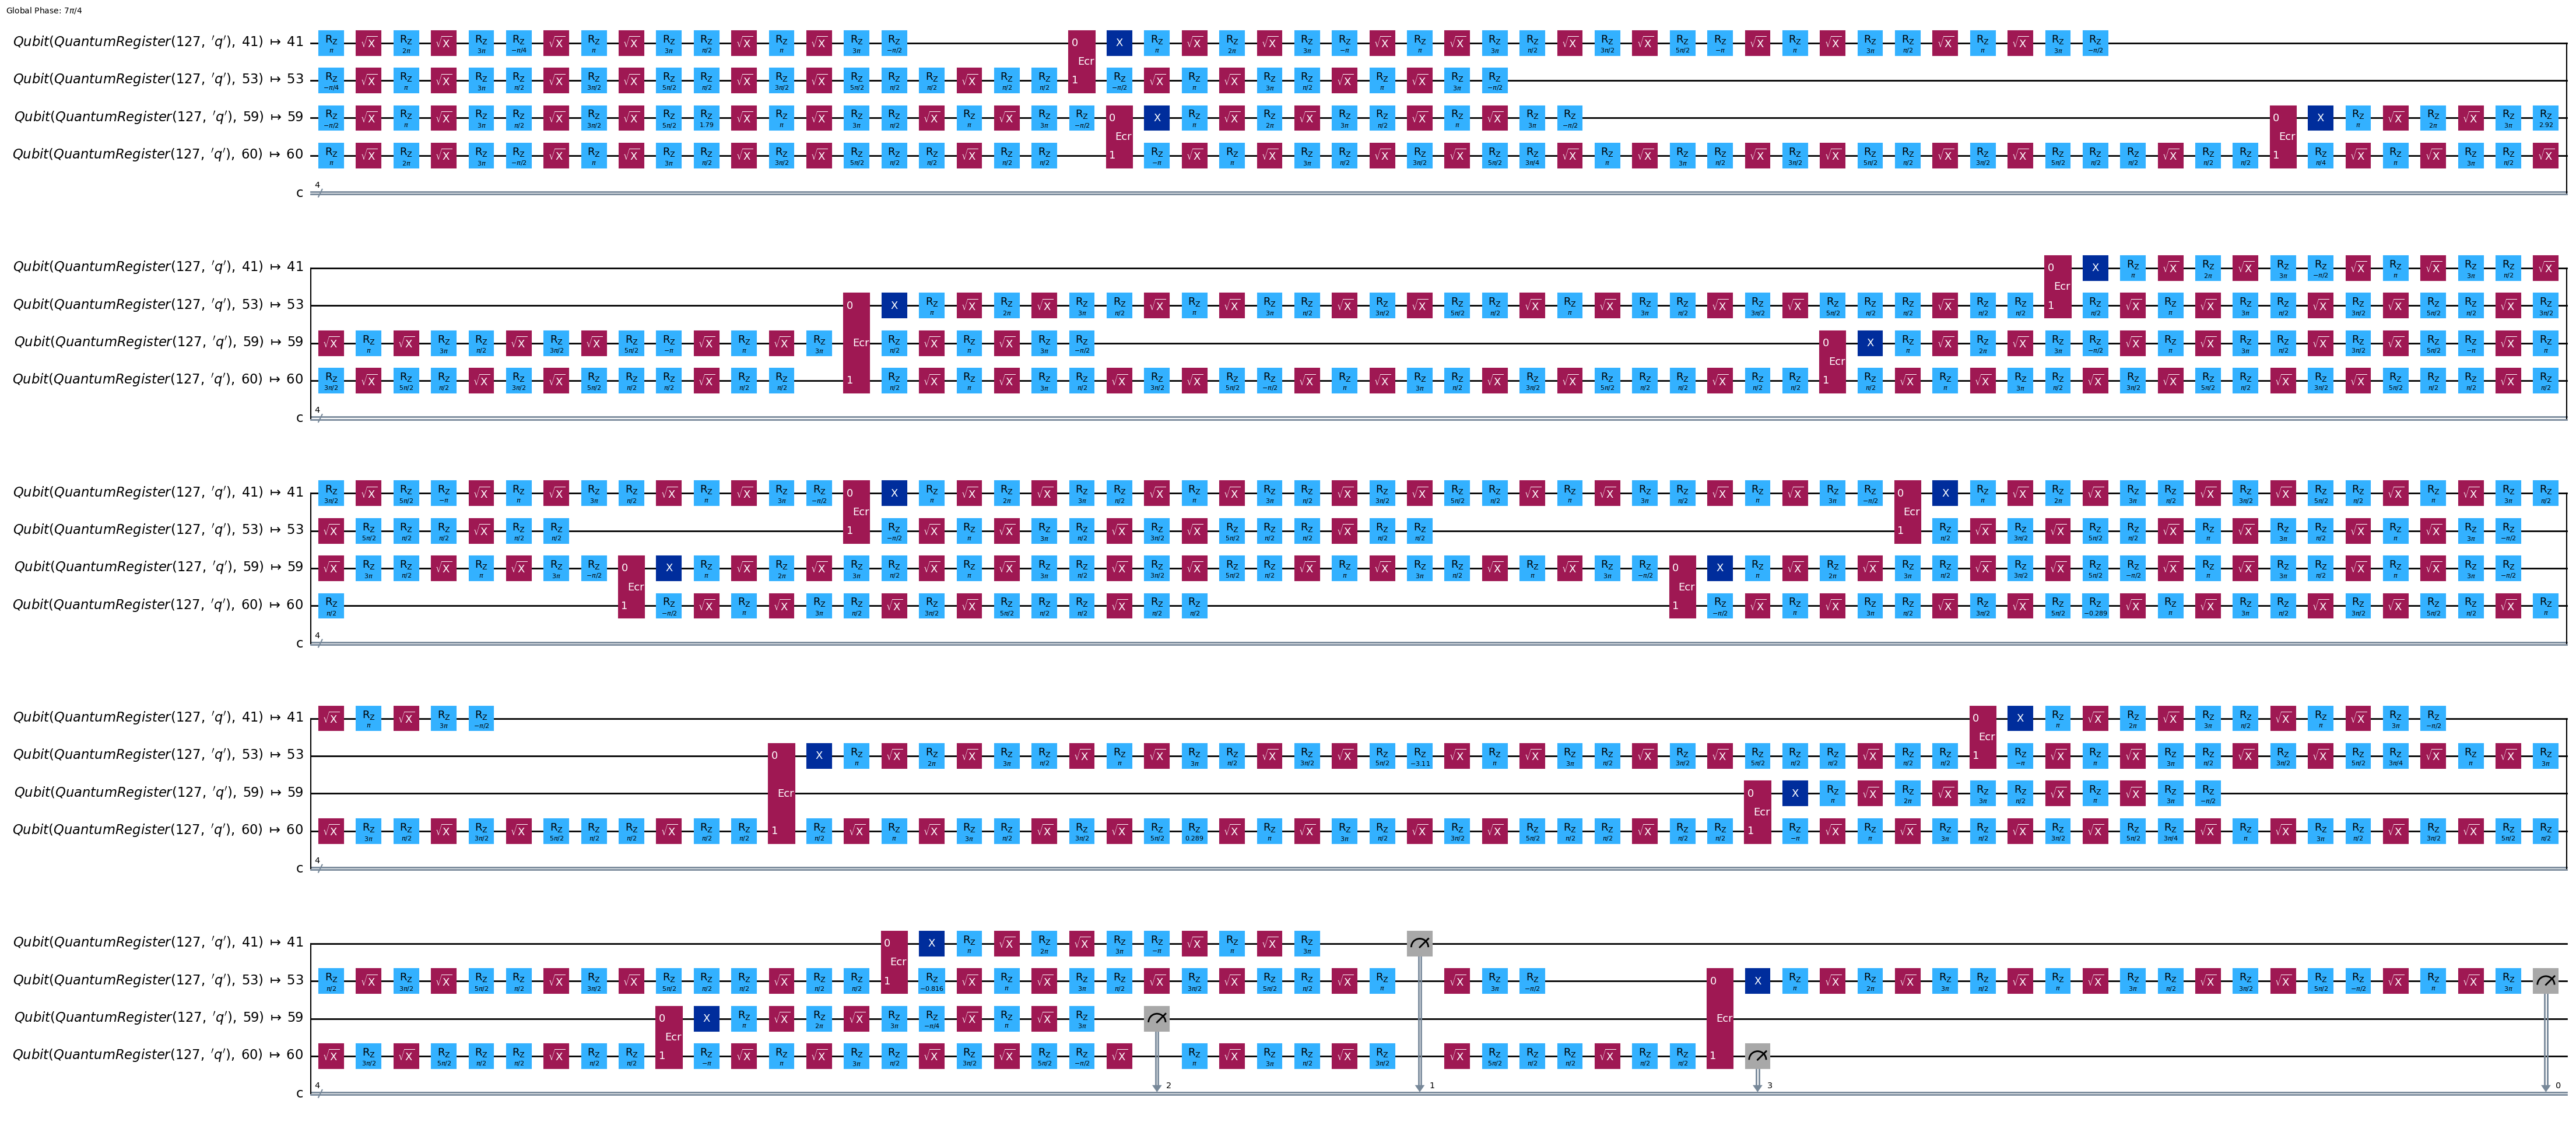

In [115]:
job_dd.inputs["pubs"][3][0].draw("mpl", idle_wires=False,fold=60)


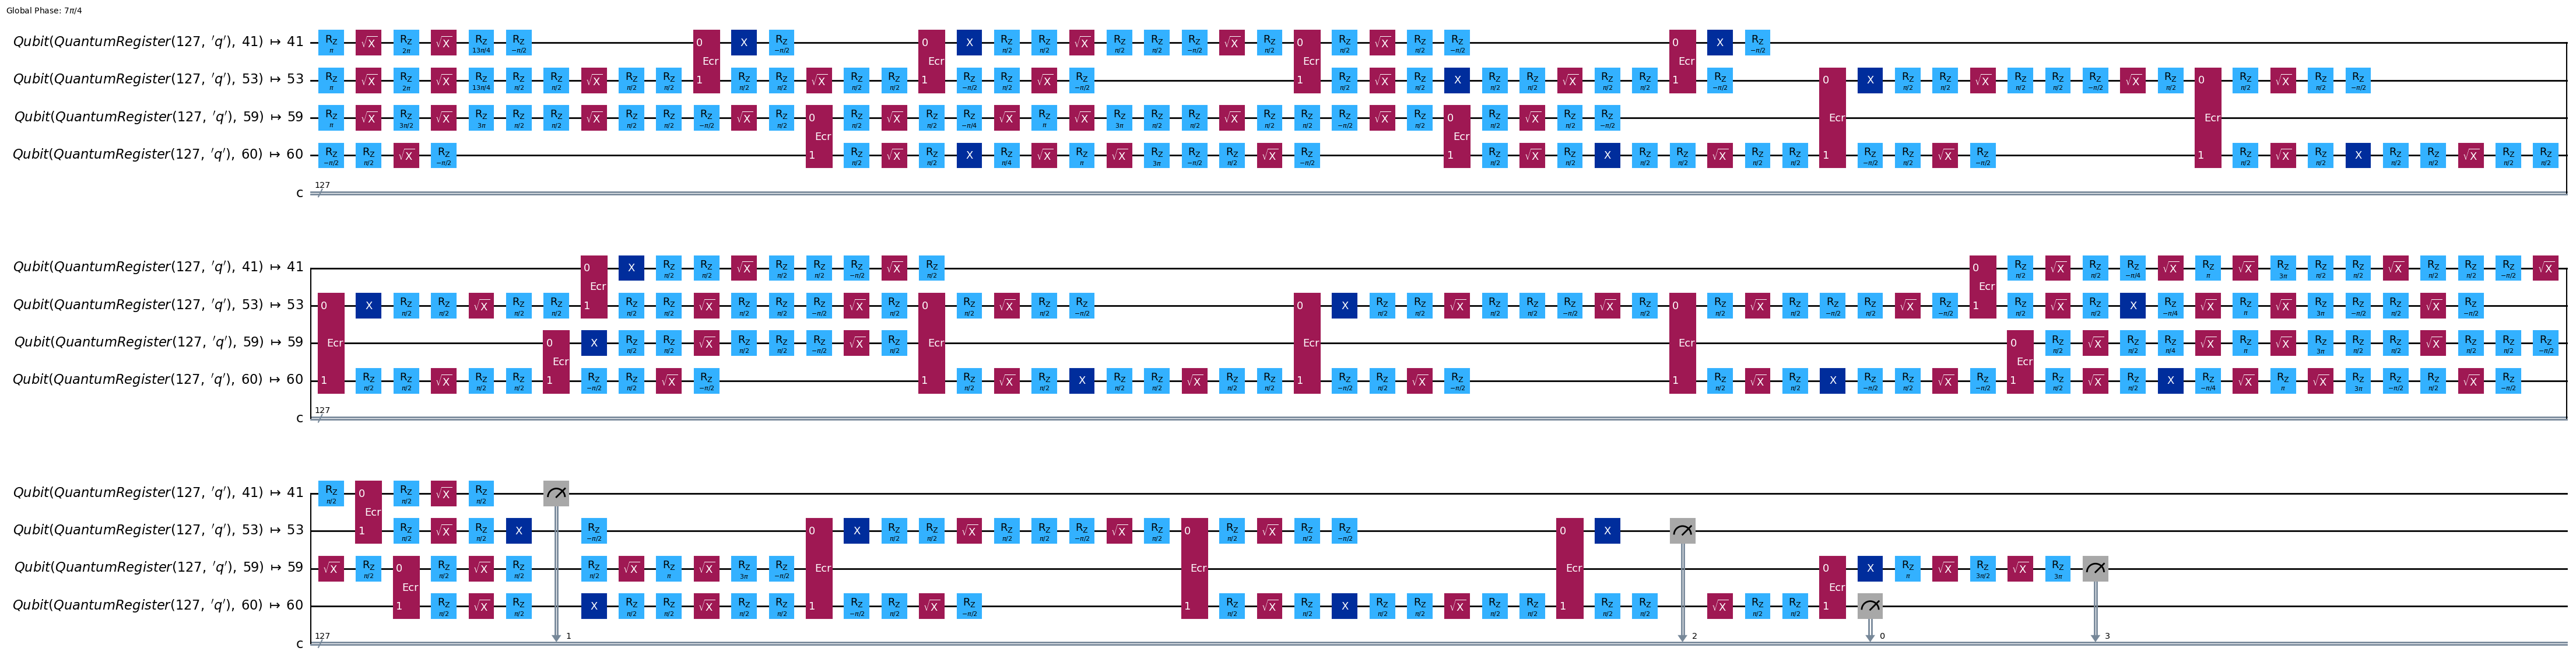

In [114]:
job_dd.inputs["pubs"][4][0].draw("mpl", idle_wires=False,fold=60)


In [116]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token='74076e69ed0d571c8e0ff8c0b2c912c28681d47426cf16a5d817825de16f7dbd95bf6ff7c604b706803b78b2e21d1dd5cacf9f1b0aa81d672d938bded8049a17'
)
job = service.job('ct5tn8x2tw9g008mbr4g')
job_result = job.result()

# To get counts for a particular pub result, use 
#
pub_result = job_result[0].data.c.get_counts()
#
# where <idx> is the index of the pub and <classical register> is the name of the classical register. 
# You can use circuit.cregs to find the name of the classical registers.



In [139]:
job_result[20].data.c.get_counts()

{'0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000111': 3489,
 '0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000011': 186,
 '0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000101': 134,
 '0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001': 77,
 '0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000010': 25,
 '0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000110': 70,
 '0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000100': 16,
 '000000000000000000000000000000000000000000